# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [4]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


## Sampling

In [5]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(2400)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

0    5700
1    3300
Name: label, dtype: int64

1    5700
0    5700
Name: label, dtype: int64

In [5]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(500)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

# 60-40

0    5700
1    3300
Name: label, dtype: int64

0    5700
1    3800
Name: label, dtype: int64

In [6]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(5250, replace=True)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

# 40-60

0    5700
1    3300
Name: label, dtype: int64

1    8550
0    5700
Name: label, dtype: int64

In [5]:
df = data["train"]
df.label.value_counts()
zeros = df[df["label"]==0].sample(3000)
df = pd.concat((df, zeros))
df.label.value_counts()
data["train"] = df

0    5700
1    3300
Name: label, dtype: int64

0    8700
1    3300
Name: label, dtype: int64

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [5]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [6]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



In [7]:
from facebook_hateful_memes_detector.utils import in_notebook, CNNHead, MultiLayerTransformerDecoderHead, AveragedLinearHead, OneTokenPositionLinearHead, MultiTaskForward, CNN2DHead
def fb_detr_loss_builder(n_dims, n_tokens, n_out, dropout, loss="classification"):
    loss = "classification" if loss is None else loss
    cnn = MultiLayerTransformerDecoderHead(n_dims, n_tokens, n_out, dropout, 
                                           gaussian_noise=0.0, loss=loss, n_layers=3)
    mtf = MultiTaskForward([cnn])
    return mtf

# Fasttext 1D CNN

In [ ]:
epochs = 15
model_fn = model_builder(Fasttext1DCNNModel,
                         dict(
                             classifier_dims=256,
                             num_classes=2,
                             n_layers=2,
                             final_layer_builder=fb_1d_loss_builder,
                             gaussian_noise=0.15,
                             dropout=0.2,
                             embedding_dims=256,
                             internal_dims=512,
                             fasttext_file="crawl-300d-2M-subword.bin",
                             featurizer="transformer",
                             loss="focal",
                             dice_loss_coef=0.0,
                             auc_loss_coef=0.0,
                         ),
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    model_call_back=reg_sched,
    scheduler_init_fn=scheduler_init_fn,
    show_model_stats=False,
    sampling_policy="without_replacement",
    validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 0.738	0.734
# 0.730	0.715
# 0.730	0.715
# 0.734	0.731
# 0.746	0.712

# Lang Features Model

In [ ]:
epochs = 15
batch_size = 256
# fasttext_crawl 1.9s
# spacy 1.8s
# full_view 1.4s 0.659	0.651
# gensim 7.5s # 0.718	0.737
# nltk 3s 0.609	0.585
# "spacy", "key_phrases" 4.2s 0.688	0.670
# "fasttext_crawl", "spacy", "key_phrases", "gensim" 20s 0.763	0.729 2h 49m
# "fasttext_crawl", "gensim" 11s 0.749	0.733 1h 47m
# gensim 8s 0.751	0.733 1h 20m

all_caps = [
    "fasttext_crawl", "spacy", "full_view", "key_phrases", "nltk", "gensim"
]  # "snlp", "ibm_max", "tmoji", "key_phrases", "full_view", "spacy", "nltk", "fasttext_crawl"
all_caps = [
    "full_view",
]
all_caps = ["fasttext_crawl", "spacy", "key_phrases", "nltk"]
all_caps = ["fasttext_crawl", "gensim"]
model_fn = model_builder(LangFeaturesModel,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.2,
                              dropout=0.2,
                              embedding_dims=256,
                              internal_dims=512,
                              capabilities=all_caps,
                              featurizer="transformer",
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              n_layers=2,
                              final_layer_builder=fb_1d_loss_builder),
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    show_model_stats=False,
    sampling_policy="without_replacement",
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# BERT Models

## Actibus/Bert_REview

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 1.087533 LR = 0.00000007



Epoch =  2 Loss = 0.299429 LR = 0.00000014



Epoch =  3 Loss = 0.234684 LR = 0.00000021



Epoch =  4 Loss = 0.228003 LR = 0.00000028


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.589  0.590 0.507 0.677 1.000  1.000 1.000 1.000
1.000  0.603  0.604 0.518 0.677 1.000  1.000 1.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1671,0.610,1.000,0.000,1642,0.636,1.000,1.000,899,0.547,1.000,0.000
1,839,0.597,1.000,1.000,1730,0.632,1.000,1.000,413,0.624,1.000,0.000
2,422,0.555,1.000,0.000,171,0.621,1.000,1.000,1082,0.597,1.000,0.000
3,151,0.613,1.000,1.000,377,0.579,1.000,1.000,649,0.554,1.000,1.000


scores =  {'map': '0.5268', 'acc': '0.3667', 'auc': '0.6558'}
Epoch =  4 Train = 0.661150 Val = 0.655751



Epoch =  5 Loss = 0.232527 LR = 0.00000035



Epoch =  6 Loss = 0.205769 LR = 0.00000042



Epoch =  7 Loss = 0.231055 LR = 0.00000049


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.420  0.420 0.381 0.455 0.000  0.000 0.000 0.000
1.000  0.426  0.426 0.381 0.461 0.000  0.000 0.000 0.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,731,0.427,0.000,1.000,1322,0.419,0.000,1.000,1326,0.454,0.000,1.000
1,1093,0.425,0.000,0.000,711,0.426,0.000,1.000,755,0.431,0.000,1.000
2,1348,0.395,0.000,0.000,735,0.412,0.000,1.000,24,0.443,0.000,0.000
3,898,0.437,0.000,1.000,613,0.395,0.000,0.000,1782,0.413,0.000,0.000


scores =  {'map': '0.5255', 'acc': '0.6333', 'auc': '0.6510'}
Epoch =  7 Train = 0.659517 Val = 0.650976



Epoch =  8 Loss = 0.209674 LR = 0.00000056



Epoch =  9 Loss = 0.193823 LR = 0.00000062


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.474  0.474 0.445 0.520 0.017  0.000 0.000 1.000
1.000  0.482  0.482 0.446 0.528 0.117  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1369,0.486,0.000,1.000,1011,0.459,0.000,0.000,706,0.480,0.000,1.000
1,398,0.479,0.000,0.000,1540,0.504,1.000,1.000,640,0.470,0.000,1.000
2,293,0.483,0.000,0.000,1340,0.474,0.000,0.000,831,0.483,0.000,0.000
3,1314,0.486,0.000,1.000,182,0.483,0.000,1.000,974,0.489,0.000,1.000


scores =  {'map': '0.5554', 'acc': '0.6656', 'auc': '0.6691'}
Epoch =  9 Train = 0.673059 Val = 0.669145



Epoch =  10 Loss = 0.182542 LR = 0.00000069



Epoch =  11 Loss = 0.176443 LR = 0.00000076


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.399  0.394 0.323 0.558 0.011  0.000 0.000 1.000
1.000  0.430  0.423 0.335 0.558 0.085  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,480,0.462,0.000,1.000,330,0.406,0.000,1.000,284,0.418,0.000,0.000
1,1672,0.342,0.000,0.000,537,0.431,0.000,0.000,1100,0.376,0.000,0.000
2,1228,0.376,0.000,0.000,887,0.455,0.000,0.000,1301,0.335,0.000,0.000
3,1288,0.458,0.000,1.000,192,0.381,0.000,0.000,901,0.365,0.000,1.000


scores =  {'map': '0.5706', 'acc': '0.6572', 'auc': '0.6847'}
Epoch =  11 Train = 0.686070 Val = 0.684746



Epoch =  12 Loss = 0.182500 LR = 0.00000083



Epoch =  13 Loss = 0.174603 LR = 0.00000090



Epoch =  14 Loss = 0.169052 LR = 0.00000097


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.403  0.397 0.368 0.524 0.004  0.000 0.000 1.000
1.000  0.424  0.412 0.369 0.543 0.029  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,950,0.389,0.000,0.000,34,0.404,0.000,1.000,1287,0.390,0.000,1.000
1,1557,0.402,0.000,0.000,456,0.442,0.000,0.000,457,0.393,0.000,1.000
2,1211,0.378,0.000,0.000,278,0.413,0.000,0.000,420,0.430,0.000,0.000
3,1740,0.401,0.000,0.000,977,0.405,0.000,0.000,1776,0.458,0.000,0.000


scores =  {'map': '0.5869', 'acc': '0.6411', 'auc': '0.6999'}
Epoch =  14 Train = 0.704257 Val = 0.699865



Epoch =  15 Loss = 0.182519 LR = 0.00000100



Epoch =  16 Loss = 0.174533 LR = 0.00000099



Epoch =  17 Loss = 0.173043 LR = 0.00000099


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.460  0.445 0.418 0.617 0.136  0.000 0.000 1.000
1.000  0.496  0.478 0.423 0.633 0.415  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1640,0.430,0.000,0.000,439,0.586,1.000,1.000,1388,0.446,0.000,1.000
1,1602,0.439,0.000,0.000,1497,0.457,0.000,0.000,62,0.448,0.000,1.000
2,1709,0.461,0.000,0.000,980,0.444,0.000,1.000,338,0.544,1.000,1.000
3,683,0.432,0.000,0.000,1233,0.431,0.000,0.000,605,0.431,0.000,0.000


scores =  {'map': '0.6005', 'acc': '0.6994', 'auc': '0.7093'}
Epoch =  17 Train = 0.713022 Val = 0.709263



Epoch =  18 Loss = 0.168151 LR = 0.00000097



Epoch =  19 Loss = 0.167836 LR = 0.00000095


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.486  0.463 0.417 0.643 0.323  0.000 0.000 1.000
1.000  0.534  0.534 0.421 0.647 0.617  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,545,0.566,1.000,0.000,521,0.479,0.000,1.000,855,0.535,1.000,1.000
1,374,0.603,1.000,1.000,100,0.545,1.000,0.000,588,0.602,1.000,1.000
2,877,0.462,0.000,0.000,1545,0.460,0.000,0.000,293,0.435,0.000,0.000
3,1560,0.463,0.000,0.000,78,0.502,1.000,1.000,825,0.560,1.000,0.000


scores =  {'map': '0.6038', 'acc': '0.6550', 'auc': '0.7158'}
Epoch =  19 Train = 0.722081 Val = 0.715836



Epoch =  20 Loss = 0.166845 LR = 0.00000093



Epoch =  21 Loss = 0.167203 LR = 0.00000091



Epoch =  22 Loss = 0.164897 LR = 0.00000088



Epoch =  23 Loss = 0.167797 LR = 0.00000085


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.448  0.441 0.415 0.586 0.047  0.000 0.000 1.000
1.000  0.477  0.460 0.418 0.605 0.264  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1389,0.469,0.000,1.000,893,0.428,0.000,0.000,759,0.444,0.000,0.000
1,1127,0.437,0.000,0.000,712,0.469,0.000,0.000,1228,0.462,0.000,1.000
2,1395,0.453,0.000,0.000,7,0.550,1.000,1.000,1230,0.441,0.000,0.000
3,1698,0.445,0.000,0.000,1364,0.500,0.000,0.000,1055,0.433,0.000,0.000


scores =  {'map': '0.6273', 'acc': '0.7000', 'auc': '0.7296'}
Epoch =  23 Train = 0.736144 Val = 0.729644



Epoch =  24 Loss = 0.170160 LR = 0.00000081



Epoch =  25 Loss = 0.165599 LR = 0.00000077



Epoch =  26 Loss = 0.166614 LR = 0.00000073



Epoch =  27 Loss = 0.165372 LR = 0.00000069


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.480  0.451 0.378 0.683 0.305  0.000 0.000 1.000
1.000  0.557  0.573 0.388 0.705 0.644  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,230,0.487,0.000,0.000,988,0.484,0.000,0.000,85,0.427,0.000,0.000
1,1172,0.392,0.000,0.000,1297,0.380,0.000,0.000,1102,0.675,1.000,1.000
2,152,0.409,0.000,0.000,247,0.400,0.000,0.000,788,0.542,1.000,0.000
3,444,0.622,1.000,0.000,1014,0.418,0.000,1.000,1036,0.429,0.000,1.000


scores =  {'map': '0.6393', 'acc': '0.6761', 'auc': '0.7378'}
Epoch =  27 Train = 0.742203 Val = 0.737755



Epoch =  28 Loss = 0.163859 LR = 0.00000065



Epoch =  29 Loss = 0.165211 LR = 0.00000060



Epoch =  30 Loss = 0.166682 LR = 0.00000056



Epoch =  31 Loss = 0.163692 LR = 0.00000051


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.468  0.453 0.426 0.659 0.139  0.000 0.000 1.000
1.000  0.521  0.489 0.434 0.683 0.470  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1507,0.458,0.000,0.000,485,0.653,1.000,1.000,291,0.455,0.000,0.000
1,624,0.452,0.000,1.000,1403,0.452,0.000,0.000,796,0.541,1.000,0.000
2,1430,0.453,0.000,0.000,78,0.451,0.000,0.000,1198,0.628,1.000,0.000
3,1728,0.500,0.000,1.000,771,0.454,0.000,1.000,28,0.551,1.000,1.000


scores =  {'map': '0.6469', 'acc': '0.7172', 'auc': '0.7399'}
Epoch =  31 Train = 0.747370 Val = 0.739918



Epoch =  32 Loss = 0.165386 LR = 0.00000046



Epoch =  33 Loss = 0.163650 LR = 0.00000042



Epoch =  34 Loss = 0.163916 LR = 0.00000037


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.479  0.463 0.322 0.667 0.348  0.000 0.000 1.000
1.000  0.550  0.557 0.359 0.680 0.692  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,939,0.516,1.000,0.000,344,0.418,0.000,0.000,6,0.557,1.000,0.000
1,834,0.529,1.000,1.000,531,0.458,0.000,0.000,367,0.639,1.000,1.000
2,1038,0.543,1.000,0.000,1506,0.346,0.000,0.000,152,0.598,1.000,1.000
3,1670,0.393,0.000,1.000,1625,0.631,1.000,1.000,1086,0.451,0.000,0.000


scores =  {'map': '0.6485', 'acc': '0.6667', 'auc': '0.7408'}
Epoch =  34 Train = 0.748957 Val = 0.740765



Epoch =  35 Loss = 0.160208 LR = 0.00000033



Epoch =  36 Loss = 0.161353 LR = 0.00000028



Epoch =  37 Loss = 0.161374 LR = 0.00000024


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.481  0.460 0.400 0.696 0.273  0.000 0.000 1.000
1.000  0.552  0.548 0.413 0.715 0.615  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,207,0.673,1.000,1.000,409,0.563,1.000,0.000,14,0.431,0.000,0.000
1,469,0.418,0.000,0.000,1602,0.539,1.000,1.000,450,0.682,1.000,1.000
2,1588,0.526,1.000,0.000,467,0.551,1.000,1.000,1609,0.413,0.000,0.000
3,1388,0.602,1.000,1.000,895,0.424,0.000,0.000,428,0.441,0.000,0.000


scores =  {'map': '0.6490', 'acc': '0.6861', 'auc': '0.7397'}
Epoch =  37 Train = 0.751601 Val = 0.739673



Epoch =  38 Loss = 0.157711 LR = 0.00000020



Epoch =  39 Loss = 0.160307 LR = 0.00000017



Epoch =  40 Loss = 0.162161 LR = 0.00000013



Epoch =  41 Loss = 0.160603 LR = 0.00000010


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.473  0.457 0.389 0.695 0.246  0.000 0.000 1.000
1.000  0.542  0.534 0.404 0.711 0.591  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1722,0.673,1.000,1.000,1770,0.466,0.000,0.000,794,0.614,1.000,0.000
1,896,0.399,0.000,0.000,1551,0.432,0.000,0.000,1253,0.428,0.000,1.000
2,901,0.459,0.000,0.000,586,0.557,1.000,0.000,1012,0.561,1.000,1.000
3,1474,0.502,1.000,0.000,1477,0.453,0.000,0.000,764,0.428,0.000,0.000


scores =  {'map': '0.6489', 'acc': '0.6939', 'auc': '0.7410'}
Epoch =  41 Train = 0.755088 Val = 0.741003



Epoch =  42 Loss = 0.160710 LR = 0.00000008



Epoch =  43 Loss = 0.161793 LR = 0.00000005



Epoch =  44 Loss = 0.159809 LR = 0.00000003


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.469  0.452 0.367 0.700 0.251  0.000 0.000 1.000
1.000  0.543  0.536 0.386 0.718 0.591  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,999,0.465,0.000,0.000,623,0.396,0.000,0.000,872,0.408,0.000,0.000
1,1435,0.651,1.000,1.000,178,0.546,1.000,0.000,169,0.424,0.000,0.000
2,466,0.460,0.000,0.000,1121,0.443,0.000,0.000,1120,0.700,1.000,1.000
3,257,0.569,1.000,0.000,1114,0.663,1.000,1.000,1496,0.397,0.000,0.000


scores =  {'map': '0.6498', 'acc': '0.6911', 'auc': '0.7413'}
Epoch =  44 Train = 0.756578 Val = 0.741320



Epoch =  45 Loss = 0.162181 LR = 0.00000002



Epoch =  46 Loss = 0.160904 LR = 0.00000001



Epoch =  47 Loss = 0.159716 LR = 0.00000000


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.474  0.458 0.364 0.705 0.275  0.000 0.000 1.000
1.000  0.549  0.546 0.385 0.723 0.623  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,810,0.395,0.000,0.000,1353,0.433,0.000,0.000,29,0.549,1.000,0.000
1,226,0.552,1.000,1.000,1184,0.641,1.000,0.000,774,0.579,1.000,0.000
2,533,0.525,1.000,0.000,293,0.504,1.000,0.000,1255,0.411,0.000,0.000
3,600,0.406,0.000,0.000,19,0.394,0.000,0.000,1302,0.469,0.000,1.000


scores =  {'map': '0.6494', 'acc': '0.6878', 'auc': '0.7415'}
Epoch =  47 Train = 0.756442 Val = 0.741475



Epoch =  48 Loss = 0.161242 LR = 0.00000000



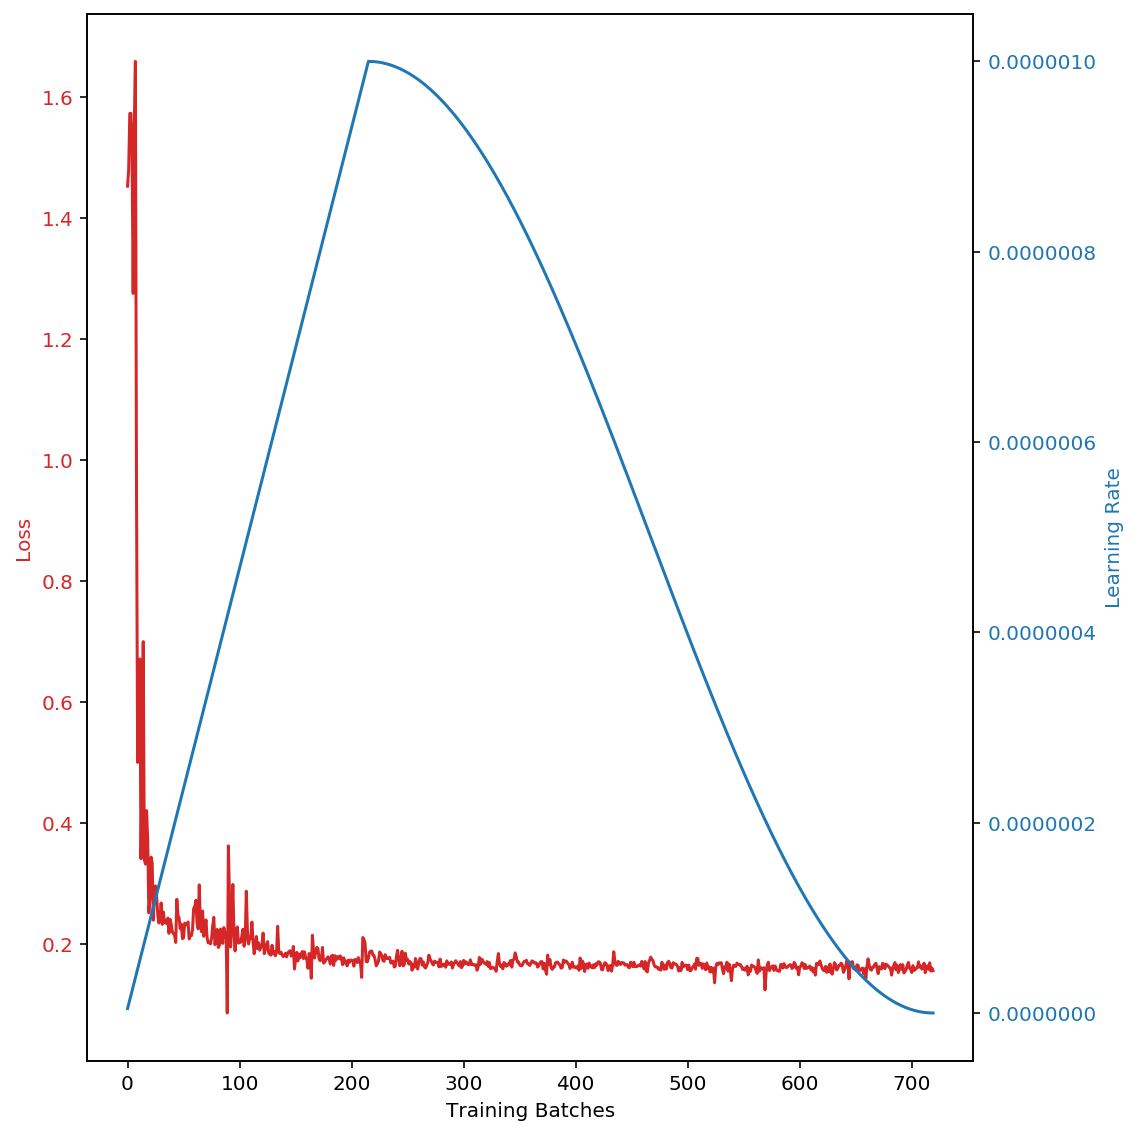

Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.475  0.458 0.364 0.705 0.275  0.000 0.000 1.000
1.000  0.550  0.546 0.385 0.723 0.624  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,387,0.663,1.000,1.000,1310,0.684,1.000,1.000,1694,0.456,0.000,0.000
1,943,0.498,0.000,0.000,1212,0.492,0.000,0.000,1344,0.492,0.000,0.000
2,214,0.563,1.000,0.000,1794,0.438,0.000,1.000,1611,0.414,0.000,0.000
3,1049,0.434,0.000,0.000,213,0.671,1.000,0.000,535,0.469,0.000,1.000


scores =  {'map': '0.6494', 'acc': '0.6878', 'auc': '0.7415'}


train   val
mean_or_std metric               
mean        map       0.656 0.649
            accuracy  0.695 0.688
            auc       0.756 0.741
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.779  0.725 0.751 4560.000     0.769  0.725 0.746 1140.000
pos     0.576  0.645 0.608 2640.000     0.567  0.624 0.595  660.000

In [8]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "9": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "10": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "11": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model="activebus/BERT_Review",
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.761	0.749 (0.703	0.691)


## NSP Style Finetuned

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.341185 LR = 0.00000007



Epoch =  2 Loss = 0.262808 LR = 0.00000014


Exception for:  keyboard | ' ' | ['char_swap' 'one_third_cut' 'word_cutout' 'half_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  3 Loss = 0.258566 LR = 0.00000021



Epoch =  4 Loss = 0.248432 LR = 0.00000028


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.433  0.433 0.401 0.455 0.000  0.000 0.000 0.000
1.000  0.436  0.436 0.414 0.458 0.000  0.000 0.000 0.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1465,0.441,0.000,1.000,771,0.448,0.000,1.000,1766,0.440,0.000,0.000
1,69,0.438,0.000,1.000,665,0.436,0.000,1.000,179,0.453,0.000,0.000
2,1641,0.434,0.000,1.000,580,0.420,0.000,0.000,1221,0.422,0.000,1.000
3,1770,0.435,0.000,0.000,336,0.445,0.000,0.000,1351,0.423,0.000,1.000


scores =  {'map': '0.4770', 'acc': '0.6333', 'auc': '0.6063'}
Epoch =  4 Train = 0.599479 Val = 0.606350



Epoch =  5 Loss = 0.243832 LR = 0.00000035



Epoch =  6 Loss = 0.243614 LR = 0.00000042



Epoch =  7 Loss = 0.241052 LR = 0.00000049


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.423  0.422 0.399 0.478 0.000  0.000 0.000 0.000
1.000  0.428  0.427 0.403 0.478 0.000  0.000 0.000 0.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1322,0.418,0.000,0.000,204,0.425,0.000,1.000,297,0.431,0.000,0.000
1,181,0.416,0.000,0.000,1742,0.411,0.000,0.000,303,0.430,0.000,0.000
2,698,0.420,0.000,0.000,782,0.424,0.000,1.000,240,0.427,0.000,0.000
3,1151,0.424,0.000,0.000,742,0.448,0.000,1.000,321,0.429,0.000,0.000


scores =  {'map': '0.4823', 'acc': '0.6333', 'auc': '0.6294'}
Epoch =  7 Train = 0.629577 Val = 0.629440



Epoch =  8 Loss = 0.240066 LR = 0.00000056



Epoch =  9 Loss = 0.239938 LR = 0.00000062


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.468  0.466 0.441 0.521 0.016  0.000 0.000 1.000
1.000  0.474  0.473 0.443 0.524 0.041  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,44,0.466,0.000,0.000,1030,0.480,0.000,1.000,1613,0.466,0.000,0.000
1,1235,0.472,0.000,1.000,696,0.468,0.000,0.000,1133,0.466,0.000,0.000
2,1623,0.456,0.000,0.000,1224,0.444,0.000,0.000,1253,0.490,0.000,0.000
3,1524,0.458,0.000,0.000,1286,0.477,0.000,0.000,1661,0.478,0.000,0.000


scores =  {'map': '0.4861', 'acc': '0.6383', 'auc': '0.6327'}
Epoch =  9 Train = 0.638754 Val = 0.632749



Epoch =  10 Loss = 0.241085 LR = 0.00000069



Epoch =  11 Loss = 0.240531 LR = 0.00000076


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.390  0.387 0.327 0.488 0.000  0.000 0.000 0.000
1.000  0.403  0.402 0.339 0.487 0.000  0.000 0.000 0.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1180,0.385,0.000,1.000,1056,0.388,0.000,0.000,578,0.432,0.000,0.000
1,466,0.387,0.000,1.000,239,0.366,0.000,0.000,1548,0.388,0.000,0.000
2,1538,0.381,0.000,0.000,1330,0.388,0.000,1.000,220,0.432,0.000,0.000
3,933,0.363,0.000,0.000,1505,0.433,0.000,0.000,887,0.357,0.000,0.000


scores =  {'map': '0.4893', 'acc': '0.6333', 'auc': '0.6353'}
Epoch =  11 Train = 0.645109 Val = 0.635261



Epoch =  12 Loss = 0.237830 LR = 0.00000083



Epoch =  13 Loss = 0.234951 LR = 0.00000090



Epoch =  14 Loss = 0.235900 LR = 0.00000097


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.481  0.481 0.441 0.512 0.111  0.000 0.000 1.000
1.000  0.491  0.495 0.445 0.516 0.291  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1252,0.468,0.000,1.000,1472,0.485,0.000,0.000,1470,0.497,0.000,0.000
1,559,0.473,0.000,0.000,1734,0.472,0.000,1.000,1115,0.500,1.000,1.000
2,545,0.482,0.000,0.000,248,0.479,0.000,0.000,1029,0.472,0.000,1.000
3,1748,0.500,0.000,1.000,372,0.489,0.000,0.000,234,0.494,0.000,1.000


scores =  {'map': '0.5557', 'acc': '0.6694', 'auc': '0.6867'}
Epoch =  14 Train = 0.693642 Val = 0.686718



Epoch =  15 Loss = 0.234672 LR = 0.00000100



Epoch =  16 Loss = 0.234630 LR = 0.00000099



Epoch =  17 Loss = 0.235014 LR = 0.00000099


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.454  0.450 0.444 0.530 0.029  0.000 0.000 1.000
1.000  0.467  0.454 0.446 0.536 0.141  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,292,0.470,0.000,0.000,1267,0.451,0.000,1.000,796,0.450,0.000,1.000
1,55,0.447,0.000,0.000,394,0.461,0.000,0.000,1375,0.451,0.000,1.000
2,276,0.469,0.000,0.000,1552,0.451,0.000,0.000,223,0.449,0.000,0.000
3,42,0.454,0.000,0.000,530,0.449,0.000,0.000,156,0.449,0.000,0.000


scores =  {'map': '0.5970', 'acc': '0.6667', 'auc': '0.7134'}
Epoch =  17 Train = 0.717965 Val = 0.713388



Epoch =  18 Loss = 0.233643 LR = 0.00000097



Epoch =  19 Loss = 0.233648 LR = 0.00000095


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.486  0.468 0.461 0.585 0.234  0.000 0.000 1.000
1.000  0.520  0.515 0.461 0.588 0.570  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,206,0.583,1.000,1.000,32,0.466,0.000,0.000,862,0.463,0.000,0.000
1,1125,0.463,0.000,0.000,1027,0.493,0.000,0.000,1399,0.490,0.000,1.000
2,303,0.467,0.000,0.000,1792,0.462,0.000,0.000,1610,0.462,0.000,0.000
3,654,0.581,1.000,1.000,688,0.545,1.000,0.000,63,0.485,0.000,0.000


scores =  {'map': '0.6236', 'acc': '0.6939', 'auc': '0.7267'}
Epoch =  19 Train = 0.730838 Val = 0.726671



Epoch =  20 Loss = 0.233340 LR = 0.00000093



Epoch =  21 Loss = 0.232537 LR = 0.00000091



Epoch =  22 Loss = 0.232697 LR = 0.00000088



Epoch =  23 Loss = 0.232259 LR = 0.00000085


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.417  0.386 0.348 0.608 0.132  0.000 0.000 1.000
1.000  0.480  0.473 0.361 0.621 0.439  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1706,0.384,0.000,0.000,1050,0.380,0.000,1.000,113,0.405,0.000,0.000
1,542,0.384,0.000,0.000,612,0.606,1.000,1.000,427,0.381,0.000,0.000
2,1171,0.387,0.000,1.000,1745,0.381,0.000,0.000,544,0.426,0.000,0.000
3,684,0.398,0.000,0.000,73,0.388,0.000,0.000,944,0.379,0.000,0.000


scores =  {'map': '0.6280', 'acc': '0.7106', 'auc': '0.7344'}
Epoch =  23 Train = 0.742126 Val = 0.734399



Epoch =  24 Loss = 0.232977 LR = 0.00000081



Epoch =  25 Loss = 0.232668 LR = 0.00000077



Epoch =  26 Loss = 0.231241 LR = 0.00000073



Epoch =  27 Loss = 0.231233 LR = 0.00000069


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.434  0.411 0.310 0.664 0.143  0.000 0.000 1.000
1.000  0.514  0.492 0.324 0.672 0.479  0.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,918,0.373,0.000,0.000,400,0.407,0.000,1.000,182,0.411,0.000,0.000
1,1405,0.465,0.000,0.000,997,0.411,0.000,1.000,297,0.378,0.000,0.000
2,1412,0.396,0.000,0.000,437,0.650,1.000,1.000,895,0.412,0.000,0.000
3,1017,0.459,0.000,1.000,6,0.388,0.000,1.000,731,0.426,0.000,0.000


scores =  {'map': '0.6452', 'acc': '0.7183', 'auc': '0.7427'}
Epoch =  27 Train = 0.750745 Val = 0.742749



Epoch =  28 Loss = 0.231210 LR = 0.00000065



Epoch =  29 Loss = 0.232375 LR = 0.00000060



Epoch =  30 Loss = 0.231544 LR = 0.00000056



Epoch =  31 Loss = 0.231445 LR = 0.00000051


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.453  0.420 0.407 0.646 0.182  0.000 0.000 1.000
1.000  0.525  0.517 0.409 0.654 0.524  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1317,0.417,0.000,0.000,23,0.420,0.000,1.000,941,0.420,0.000,0.000
1,1249,0.477,0.000,0.000,1341,0.423,0.000,0.000,780,0.415,0.000,0.000
2,250,0.419,0.000,0.000,41,0.423,0.000,0.000,210,0.630,1.000,1.000
3,1275,0.590,1.000,1.000,1107,0.415,0.000,0.000,593,0.420,0.000,0.000


scores =  {'map': '0.6418', 'acc': '0.7106', 'auc': '0.7420'}
Epoch =  31 Train = 0.757277 Val = 0.741969



Epoch =  32 Loss = 0.230764 LR = 0.00000046



Epoch =  33 Loss = 0.231025 LR = 0.00000042



Epoch =  34 Loss = 0.230962 LR = 0.00000037


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.412  0.406 0.164 0.681 0.192  0.000 0.000 1.000
1.000  0.519  0.516 0.185 0.694 0.539  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1153,0.682,1.000,1.000,1230,0.463,0.000,1.000,182,0.504,1.000,0.000
1,1768,0.570,1.000,1.000,1250,0.586,1.000,0.000,1694,0.407,0.000,1.000
2,705,0.440,0.000,0.000,221,0.406,0.000,0.000,1364,0.348,0.000,1.000
3,1109,0.539,1.000,1.000,723,0.549,1.000,0.000,1166,0.185,0.000,0.000


scores =  {'map': '0.6407', 'acc': '0.7094', 'auc': '0.7424'}
Epoch =  34 Train = 0.763608 Val = 0.742370



Epoch =  35 Loss = 0.231166 LR = 0.00000033



Epoch =  36 Loss = 0.231249 LR = 0.00000028



Epoch =  37 Loss = 0.230280 LR = 0.00000024


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.442  0.426 0.191 0.755 0.289  0.000 0.000 1.000
1.000  0.567  0.575 0.203 0.774 0.635  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1574,0.282,0.000,0.000,1340,0.740,1.000,1.000,1526,0.427,0.000,1.000
1,1303,0.647,1.000,1.000,608,0.522,1.000,0.000,111,0.423,0.000,1.000
2,1109,0.427,0.000,1.000,544,0.326,0.000,0.000,257,0.727,1.000,1.000
3,1089,0.454,0.000,0.000,1408,0.269,0.000,0.000,1125,0.534,1.000,0.000


scores =  {'map': '0.6469', 'acc': '0.6833', 'auc': '0.7440'}
Epoch =  37 Train = 0.769177 Val = 0.743991



Epoch =  38 Loss = 0.229847 LR = 0.00000020



Epoch =  39 Loss = 0.230856 LR = 0.00000017



Epoch =  40 Loss = 0.230828 LR = 0.00000013



Epoch =  41 Loss = 0.229710 LR = 0.00000010


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.427  0.426 0.160 0.748 0.284  0.000 0.000 1.000
1.000  0.557  0.567 0.179 0.773 0.630  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1128,0.365,0.000,0.000,38,0.423,0.000,0.000,31,0.359,0.000,0.000
1,991,0.683,1.000,1.000,19,0.580,1.000,1.000,526,0.509,1.000,0.000
2,1591,0.428,0.000,0.000,471,0.225,0.000,0.000,1757,0.422,0.000,0.000
3,359,0.219,0.000,0.000,1467,0.430,0.000,0.000,119,0.691,1.000,1.000


scores =  {'map': '0.6508', 'acc': '0.6844', 'auc': '0.7465'}
Epoch =  41 Train = 0.774229 Val = 0.746544



Epoch =  42 Loss = 0.229974 LR = 0.00000008



Epoch =  43 Loss = 0.228987 LR = 0.00000005



Epoch =  44 Loss = 0.229997 LR = 0.00000003


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.431  0.423 0.195 0.804 0.249  0.000 0.000 1.000
1.000  0.568  0.560 0.219 0.828 0.589  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,970,0.303,0.000,0.000,1374,0.650,1.000,1.000,561,0.373,0.000,0.000
1,664,0.498,0.000,0.000,858,0.630,1.000,0.000,656,0.601,1.000,1.000
2,801,0.676,1.000,1.000,1172,0.283,0.000,0.000,418,0.669,1.000,1.000
3,1327,0.462,0.000,1.000,1539,0.792,1.000,1.000,836,0.423,0.000,0.000


scores =  {'map': '0.6501', 'acc': '0.6917', 'auc': '0.7462'}
Epoch =  44 Train = 0.775635 Val = 0.746233



Epoch =  45 Loss = 0.229880 LR = 0.00000002



Epoch =  46 Loss = 0.229692 LR = 0.00000001



Epoch =  47 Loss = 0.229680 LR = 0.00000000


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.425  0.424 0.187 0.793 0.237  0.000 0.000 1.000
1.000  0.558  0.549 0.210 0.821 0.579  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,936,0.784,1.000,1.000,915,0.681,1.000,1.000,1515,0.642,1.000,1.000
1,227,0.647,1.000,1.000,298,0.346,0.000,0.000,114,0.655,1.000,0.000
2,1675,0.451,0.000,0.000,153,0.431,0.000,1.000,616,0.766,1.000,1.000
3,551,0.607,1.000,0.000,991,0.668,1.000,1.000,603,0.425,0.000,0.000


scores =  {'map': '0.6501', 'acc': '0.6956', 'auc': '0.7460'}
Epoch =  47 Train = 0.775919 Val = 0.746043



Epoch =  48 Loss = 0.228711 LR = 0.00000000



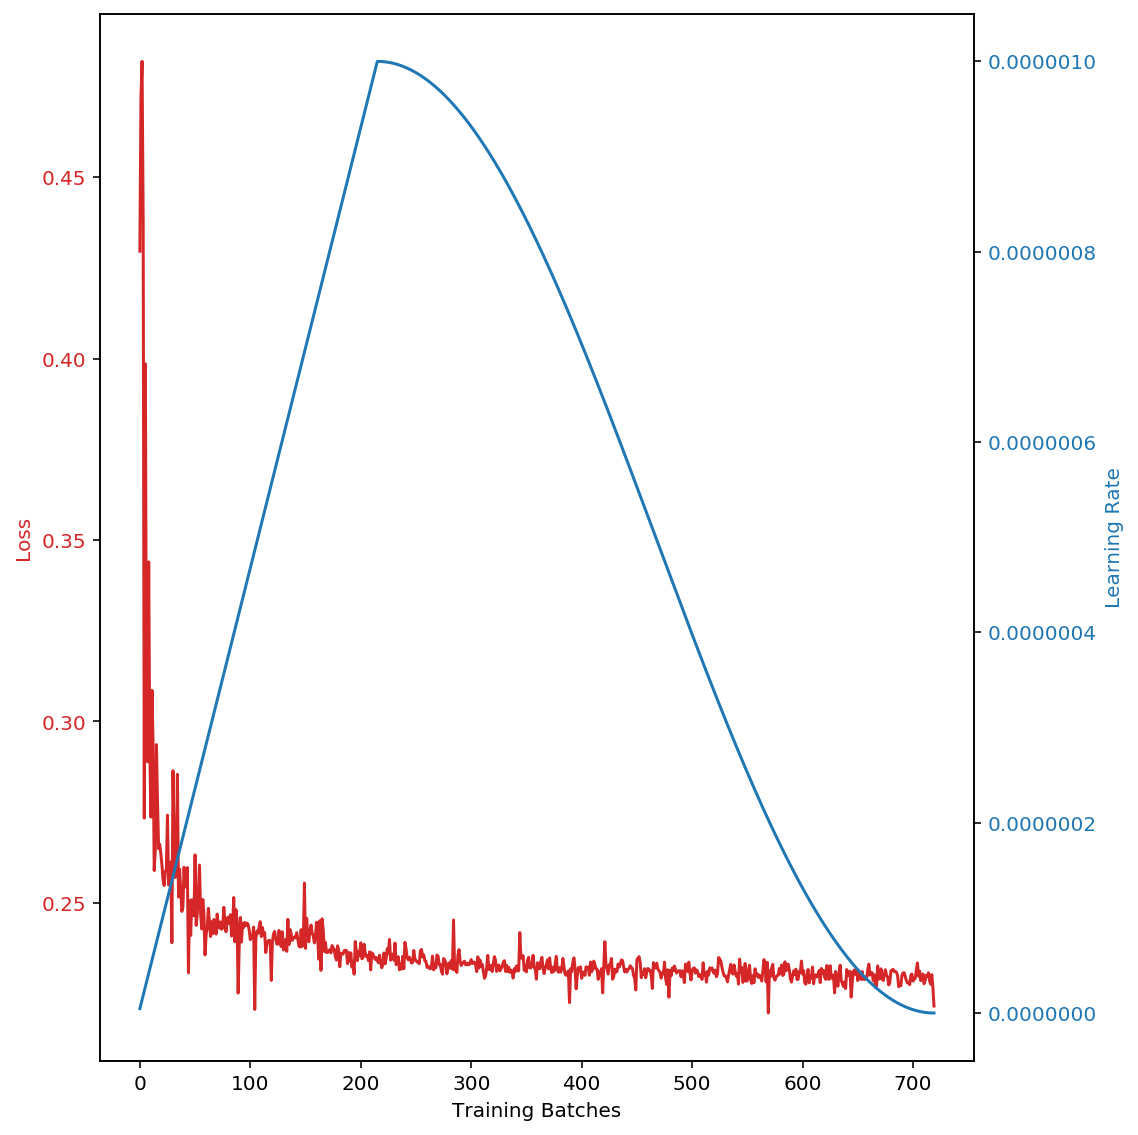

Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.425  0.424 0.187 0.794 0.237  0.000 0.000 1.000
1.000  0.559  0.549 0.210 0.822 0.579  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1401,0.367,0.000,1.000,1374,0.624,1.000,1.000,560,0.427,0.000,0.000
1,277,0.545,1.000,0.000,1542,0.503,1.000,0.000,1319,0.347,0.000,0.000
2,823,0.367,0.000,0.000,1218,0.420,0.000,0.000,695,0.242,0.000,0.000
3,1120,0.427,0.000,0.000,1784,0.359,0.000,0.000,247,0.235,0.000,0.000


scores =  {'map': '0.6502', 'acc': '0.6956', 'auc': '0.7460'}


train   val
mean_or_std metric               
mean        map       0.683 0.650
            accuracy  0.721 0.696
            auc       0.776 0.746
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.781  0.777 0.779 4560.000     0.758  0.763 0.760 1140.000
pos     0.618  0.624 0.621 2640.000     0.586  0.579 0.582  660.000

In [15]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.2,
                              dropout=0.15,
                              word_masking_proba=0.2,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              dice_loss_coef=4.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



### DETR Style

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.529112 LR = 0.00000007


Exception for:  keyboard | ' ' ' ' | ['char_delete' 'one_third_cut' 'keyboard' 'text_rotate'] argument of type 'NoneType' is not iterable

Epoch =  2 Loss = 0.233975 LR = 0.00000014



Epoch =  3 Loss = 0.206990 LR = 0.00000021



Epoch =  4 Loss = 0.198637 LR = 0.00000028


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.526  0.526 0.518 0.537       1.000  1.000 1.000 1.000
1.000        0.527  0.527 0.518 0.537       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
436,0.528,1.000,0.000
1900,0.527,1.000,0.000
4201,0.528,1.000,0.000
3465,0.524,1.000,0.000
5136,0.521,1.000,0.000
6707,0.525,1.000,0.000
4285,0.527,1.000,1.000
6057,0.524,1.000,1.000
1672,0.526,1.000,1.000
5643,0.523,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.526  0.526 0.519 0.535       1.000  1.000 1.000 1.000
1.000        0.527  0.527 0.520 0.539       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
1208,0.524,1.000,0.000
1428,0.527,1.000,0.000
716,0.525,1.000,0.000
452,0.524,1.000,0.000
122,0.526,1.000,0.000
117,0.526,1.000,0.000
1039,0.527,1.000,1.000
1403,0.534,1.000,0.000
591,0.527,1.000,0.000
1772,0.526,1.000,0.000


Epoch =  4 Train = 0.605838 Val = 0.594082



Epoch =  5 Loss = 0.205126 LR = 0.00000035



Epoch =  6 Loss = 0.198211 LR = 0.00000042



Epoch =  7 Loss = 0.197796 LR = 0.00000049


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.415  0.415 0.406 0.430       0.000  0.000 0.000 0.000
1.000        0.417  0.416 0.406 0.431       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
6413,0.417,0.000,1.000
6060,0.414,0.000,0.000
3516,0.418,0.000,0.000
6858,0.410,0.000,0.000
646,0.413,0.000,1.000
2968,0.424,0.000,0.000
3564,0.415,0.000,0.000
2014,0.423,0.000,1.000
1206,0.415,0.000,0.000
5735,0.415,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.415  0.415 0.406 0.428       0.000  0.000 0.000 0.000
1.000        0.417  0.417 0.407 0.432       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1082,0.418,0.000,0.000
1029,0.408,0.000,0.000
1725,0.415,0.000,0.000
1473,0.416,0.000,1.000
553,0.420,0.000,0.000
223,0.413,0.000,0.000
884,0.414,0.000,0.000
941,0.420,0.000,0.000
1759,0.415,0.000,1.000
1755,0.411,0.000,1.000


Epoch =  7 Train = 0.626044 Val = 0.620737



Epoch =  8 Loss = 0.212310 LR = 0.00000056



Epoch =  9 Loss = 0.189995 LR = 0.00000062


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.498  0.498 0.494 0.506       0.137  0.000 0.000 1.000
1.000        0.499  0.499 0.494 0.507       0.265  0.000 0.000 1.000

,Probability,Predictions,Labels
5862,0.498,0.000,0.000
5122,0.497,0.000,1.000
1406,0.498,0.000,0.000
5083,0.500,1.000,1.000
3765,0.497,0.000,1.000
1565,0.500,0.000,0.000
5627,0.496,0.000,1.000
5716,0.498,0.000,1.000
5736,0.498,0.000,1.000
5733,0.497,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.498  0.498 0.493 0.505       0.164  0.000 0.000 1.000
1.000        0.499  0.499 0.494 0.507       0.267  0.000 0.000 1.000

,Probability,Predictions,Labels
1548,0.500,1.000,0.000
1331,0.496,0.000,1.000
1633,0.498,0.000,0.000
1037,0.504,1.000,0.000
36,0.495,0.000,1.000
442,0.502,1.000,1.000
71,0.498,0.000,1.000
1017,0.495,0.000,1.000
663,0.496,0.000,0.000
1394,0.500,1.000,0.000


Epoch =  9 Train = 0.624843 Val = 0.617760



Epoch =  10 Loss = 0.184634 LR = 0.00000069



Epoch =  11 Loss = 0.180349 LR = 0.00000076


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.457  0.457 0.445 0.476       0.000  0.000 0.000 0.000
1.000        0.460  0.460 0.446 0.477       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1900,0.465,0.000,1.000
2993,0.452,0.000,0.000
1904,0.457,0.000,0.000
6487,0.457,0.000,1.000
5029,0.459,0.000,0.000
6796,0.452,0.000,0.000
3516,0.460,0.000,0.000
3427,0.471,0.000,1.000
3158,0.453,0.000,0.000
3320,0.459,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.458  0.457 0.445 0.474       0.000  0.000 0.000 0.000
1.000        0.460  0.460 0.447 0.478       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1765,0.465,0.000,1.000
476,0.464,0.000,1.000
728,0.456,0.000,0.000
1673,0.454,0.000,0.000
1351,0.451,0.000,1.000
9,0.460,0.000,0.000
402,0.447,0.000,1.000
111,0.451,0.000,0.000
835,0.461,0.000,0.000
338,0.464,0.000,0.000


Epoch =  11 Train = 0.636357 Val = 0.632468



Epoch =  12 Loss = 0.177390 LR = 0.00000083



Epoch =  13 Loss = 0.183543 LR = 0.00000090



Epoch =  14 Loss = 0.175410 LR = 0.00000097


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.477 0.444 0.512       0.215  0.000 0.000 1.000
1.000        0.492  0.498 0.445 0.513       0.468  0.000 0.000 1.000

,Probability,Predictions,Labels
3114,0.462,0.000,0.000
572,0.472,0.000,0.000
2374,0.512,1.000,1.000
4062,0.468,0.000,0.000
6468,0.485,0.000,0.000
6787,0.464,0.000,1.000
1501,0.479,0.000,0.000
6551,0.509,1.000,0.000
4546,0.467,0.000,0.000
5999,0.470,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.480 0.444 0.513       0.245  0.000 0.000 1.000
1.000        0.493  0.499 0.449 0.513       0.479  0.000 0.000 1.000

,Probability,Predictions,Labels
626,0.472,0.000,0.000
1570,0.478,0.000,0.000
1026,0.511,1.000,0.000
170,0.447,0.000,0.000
1439,0.467,0.000,1.000
342,0.494,0.000,0.000
1171,0.461,0.000,0.000
1260,0.510,1.000,0.000
867,0.474,0.000,0.000
1037,0.464,0.000,1.000


Epoch =  14 Train = 0.680606 Val = 0.666915



Epoch =  15 Loss = 0.173379 LR = 0.00000100



Epoch =  16 Loss = 0.170412 LR = 0.00000099



Epoch =  17 Loss = 0.167970 LR = 0.00000099


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.478  0.468 0.460 0.542       0.178  0.000 0.000 1.000
1.000        0.499  0.501 0.461 0.545       0.506  1.000 0.000 1.000

,Probability,Predictions,Labels
194,0.465,0.000,1.000
6708,0.538,1.000,1.000
5928,0.497,0.000,0.000
3145,0.520,1.000,0.000
555,0.521,1.000,1.000
4944,0.478,0.000,0.000
3072,0.513,1.000,0.000
62,0.467,0.000,0.000
3306,0.466,0.000,1.000
4272,0.470,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.479  0.469 0.461 0.541       0.189  0.000 0.000 1.000
1.000        0.499  0.503 0.461 0.542       0.518  1.000 0.000 1.000

,Probability,Predictions,Labels
858,0.525,1.000,0.000
1782,0.463,0.000,0.000
138,0.464,0.000,0.000
1526,0.501,1.000,0.000
194,0.465,0.000,0.000
1044,0.520,1.000,0.000
89,0.522,1.000,1.000
282,0.467,0.000,0.000
450,0.530,1.000,1.000
115,0.469,0.000,1.000


Epoch =  17 Train = 0.737272 Val = 0.716143



Epoch =  18 Loss = 0.162094 LR = 0.00000097



Epoch =  19 Loss = 0.170884 LR = 0.00000095


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.478 0.466 0.505       0.031  0.000 0.000 1.000
1.000        0.490  0.494 0.466 0.505       0.171  0.000 0.000 1.000

,Probability,Predictions,Labels
6251,0.470,0.000,0.000
5759,0.469,0.000,0.000
2815,0.495,0.000,1.000
6383,0.477,0.000,0.000
6635,0.495,0.000,1.000
1363,0.477,0.000,1.000
5430,0.493,0.000,1.000
3618,0.492,0.000,1.000
3378,0.473,0.000,0.000
3011,0.469,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.479 0.466 0.504       0.040  0.000 0.000 1.000
1.000        0.490  0.494 0.467 0.505       0.188  0.000 0.000 1.000

,Probability,Predictions,Labels
717,0.485,0.000,0.000
176,0.497,0.000,1.000
1539,0.494,0.000,1.000
1723,0.502,1.000,1.000
190,0.501,1.000,1.000
1483,0.498,0.000,1.000
141,0.480,0.000,0.000
1742,0.487,0.000,0.000
97,0.493,0.000,1.000
1619,0.475,0.000,0.000


Epoch =  19 Train = 0.737997 Val = 0.714369



Epoch =  20 Loss = 0.171040 LR = 0.00000093



Epoch =  21 Loss = 0.166163 LR = 0.00000091



Epoch =  22 Loss = 0.164707 LR = 0.00000088



Epoch =  23 Loss = 0.163739 LR = 0.00000085


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.465 0.462 0.548       0.061  0.000 0.000 1.000
1.000        0.486  0.470 0.462 0.553       0.285  0.000 0.000 1.000

,Probability,Predictions,Labels
2562,0.465,0.000,0.000
4142,0.465,0.000,0.000
1283,0.468,0.000,1.000
6862,0.464,0.000,0.000
5377,0.463,0.000,0.000
1624,0.525,1.000,1.000
1601,0.466,0.000,1.000
5120,0.468,0.000,0.000
2460,0.463,0.000,0.000
6271,0.469,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.471  0.465 0.462 0.546       0.071  0.000 0.000 1.000
1.000        0.486  0.470 0.462 0.552       0.295  0.000 0.000 1.000

,Probability,Predictions,Labels
1355,0.466,0.000,0.000
1605,0.534,1.000,0.000
762,0.468,0.000,0.000
912,0.465,0.000,0.000
496,0.472,0.000,0.000
1537,0.464,0.000,0.000
108,0.467,0.000,0.000
96,0.512,1.000,1.000
1200,0.466,0.000,0.000
1620,0.478,0.000,0.000


Epoch =  23 Train = 0.750888 Val = 0.714731



Epoch =  24 Loss = 0.163177 LR = 0.00000081



Epoch =  25 Loss = 0.161844 LR = 0.00000077



Epoch =  26 Loss = 0.161801 LR = 0.00000073



Epoch =  27 Loss = 0.160937 LR = 0.00000069


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.458 0.450 0.556       0.110  0.000 0.000 1.000
1.000        0.495  0.486 0.450 0.557       0.429  0.000 0.000 1.000

,Probability,Predictions,Labels
5054,0.515,1.000,1.000
7105,0.534,1.000,1.000
7110,0.496,0.000,0.000
3110,0.453,0.000,0.000
6450,0.545,1.000,1.000
2616,0.454,0.000,0.000
6022,0.464,0.000,1.000
2349,0.460,0.000,1.000
2145,0.465,0.000,0.000
4640,0.476,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.459 0.450 0.556       0.135  0.000 0.000 1.000
1.000        0.495  0.485 0.451 0.557       0.421  0.000 0.000 1.000

,Probability,Predictions,Labels
1521,0.476,0.000,1.000
1227,0.505,1.000,0.000
379,0.452,0.000,0.000
64,0.514,1.000,1.000
1392,0.453,0.000,0.000
178,0.452,0.000,0.000
701,0.486,0.000,1.000
1516,0.455,0.000,0.000
1690,0.455,0.000,0.000
1241,0.530,1.000,0.000


Epoch =  27 Train = 0.755219 Val = 0.715837



Epoch =  28 Loss = 0.162766 LR = 0.00000065



Epoch =  29 Loss = 0.160942 LR = 0.00000060



Epoch =  30 Loss = 0.161022 LR = 0.00000056



Epoch =  31 Loss = 0.163285 LR = 0.00000051


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.478 0.451 0.550       0.174  0.000 0.000 1.000
1.000        0.506  0.507 0.452 0.553       0.551  1.000 0.000 1.000

,Probability,Predictions,Labels
3502,0.472,0.000,0.000
296,0.463,0.000,0.000
5446,0.528,1.000,0.000
5296,0.542,1.000,0.000
5833,0.535,1.000,0.000
3604,0.507,1.000,1.000
6812,0.481,0.000,0.000
2239,0.537,1.000,1.000
2597,0.481,0.000,0.000
1229,0.470,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.480 0.451 0.551       0.203  0.000 0.000 1.000
1.000        0.506  0.506 0.453 0.552       0.542  1.000 0.000 1.000

,Probability,Predictions,Labels
1180,0.491,0.000,0.000
1515,0.456,0.000,1.000
471,0.514,1.000,0.000
906,0.492,0.000,1.000
424,0.470,0.000,0.000
1585,0.500,0.000,0.000
28,0.541,1.000,1.000
1581,0.547,1.000,1.000
1234,0.531,1.000,1.000
737,0.475,0.000,0.000


Epoch =  31 Train = 0.761365 Val = 0.723143



Epoch =  32 Loss = 0.160758 LR = 0.00000046



Epoch =  33 Loss = 0.157157 LR = 0.00000042



Epoch =  34 Loss = 0.162217 LR = 0.00000037


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.468 0.428 0.560       0.113  0.000 0.000 1.000
1.000        0.499  0.493 0.428 0.563       0.447  0.000 0.000 1.000

,Probability,Predictions,Labels
6502,0.500,0.000,0.000
1663,0.543,1.000,1.000
6071,0.439,0.000,1.000
51,0.457,0.000,0.000
6714,0.465,0.000,1.000
852,0.431,0.000,0.000
3553,0.511,1.000,0.000
3919,0.488,0.000,0.000
1966,0.486,0.000,0.000
6162,0.535,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.472 0.428 0.561       0.138  0.000 0.000 1.000
1.000        0.498  0.493 0.428 0.562       0.438  0.000 0.000 1.000

,Probability,Predictions,Labels
301,0.457,0.000,0.000
290,0.449,0.000,0.000
1428,0.486,0.000,1.000
1249,0.554,1.000,1.000
666,0.443,0.000,0.000
724,0.478,0.000,1.000
1609,0.482,0.000,0.000
1499,0.518,1.000,0.000
1217,0.541,1.000,1.000
1115,0.446,0.000,0.000


Epoch =  34 Train = 0.766584 Val = 0.725936



Epoch =  35 Loss = 0.158309 LR = 0.00000033



Epoch =  36 Loss = 0.156998 LR = 0.00000028



Epoch =  37 Loss = 0.160969 LR = 0.00000024


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.475 0.452 0.558       0.213  0.000 0.000 1.000
1.000        0.511  0.514 0.452 0.560       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
4151,0.514,1.000,1.000
5554,0.533,1.000,1.000
5280,0.479,0.000,0.000
1397,0.479,0.000,1.000
1553,0.500,0.000,1.000
5211,0.461,0.000,0.000
1535,0.514,1.000,0.000
2055,0.459,0.000,0.000
1253,0.548,1.000,1.000
6534,0.486,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.452 0.559       0.246  0.000 0.000 1.000
1.000        0.510  0.514 0.453 0.559       0.597  1.000 0.000 1.000

,Probability,Predictions,Labels
1698,0.457,0.000,0.000
5,0.539,1.000,1.000
185,0.541,1.000,1.000
981,0.467,0.000,0.000
585,0.483,0.000,0.000
1029,0.465,0.000,0.000
1236,0.468,0.000,1.000
41,0.459,0.000,0.000
1568,0.460,0.000,0.000
215,0.495,0.000,0.000


Epoch =  37 Train = 0.769649 Val = 0.727301



Epoch =  38 Loss = 0.159147 LR = 0.00000020



Epoch =  39 Loss = 0.158496 LR = 0.00000017



Epoch =  40 Loss = 0.160286 LR = 0.00000013



Epoch =  41 Loss = 0.159812 LR = 0.00000010


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.478  0.473 0.437 0.571       0.212  0.000 0.000 1.000
1.000        0.514  0.516 0.437 0.573       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
5005,0.470,0.000,0.000
2726,0.470,0.000,0.000
2704,0.511,1.000,1.000
4693,0.449,0.000,0.000
6558,0.482,0.000,1.000
2785,0.485,0.000,0.000
4155,0.491,0.000,0.000
7112,0.453,0.000,1.000
542,0.460,0.000,0.000
5914,0.459,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.479 0.437 0.571       0.234  0.000 0.000 1.000
1.000        0.512  0.515 0.438 0.572       0.595  1.000 0.000 1.000

,Probability,Predictions,Labels
329,0.568,1.000,1.000
1245,0.568,1.000,1.000
252,0.456,0.000,0.000
1677,0.449,0.000,0.000
1523,0.485,0.000,0.000
1154,0.464,0.000,0.000
253,0.493,0.000,1.000
1207,0.562,1.000,1.000
172,0.475,0.000,0.000
533,0.451,0.000,0.000


Epoch =  41 Train = 0.771929 Val = 0.727091



Epoch =  42 Loss = 0.158031 LR = 0.00000008


Exception for:  keyboard | '' '' | ['half_cut' 'sentence_shuffle' 'word_cutout' 'keyboard' 'stopword_insert'] argument of type 'NoneType' is not iterable

Epoch =  43 Loss = 0.155354 LR = 0.00000005



Epoch =  44 Loss = 0.156557 LR = 0.00000003


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.476  0.465 0.430 0.584       0.229  0.000 0.000 1.000
1.000        0.520  0.525 0.431 0.585       0.632  1.000 0.000 1.000

,Probability,Predictions,Labels
6448,0.490,0.000,1.000
3000,0.540,1.000,1.000
4915,0.473,0.000,0.000
53,0.582,1.000,1.000
3092,0.485,0.000,1.000
6474,0.583,1.000,1.000
5065,0.481,0.000,0.000
2628,0.503,1.000,1.000
367,0.444,0.000,1.000
611,0.486,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.470 0.430 0.585       0.255  0.000 0.000 1.000
1.000        0.517  0.522 0.431 0.585       0.611  1.000 0.000 1.000

,Probability,Predictions,Labels
1369,0.447,0.000,0.000
1493,0.553,1.000,0.000
330,0.510,1.000,0.000
1450,0.471,0.000,0.000
953,0.460,0.000,0.000
333,0.577,1.000,1.000
936,0.529,1.000,1.000
894,0.525,1.000,1.000
1442,0.438,0.000,0.000
1192,0.497,0.000,0.000


Epoch =  44 Train = 0.772742 Val = 0.726326



Epoch =  45 Loss = 0.159630 LR = 0.00000002



Epoch =  46 Loss = 0.157575 LR = 0.00000001



Epoch =  47 Loss = 0.158281 LR = 0.00000000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.472 0.431 0.586       0.258  0.000 0.000 1.000
1.000        0.524  0.529 0.432 0.587       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
5562,0.522,1.000,0.000
6479,0.486,0.000,1.000
2846,0.527,1.000,1.000
4907,0.513,1.000,0.000
7,0.495,0.000,1.000
3935,0.530,1.000,0.000
3540,0.456,0.000,0.000
2287,0.472,0.000,0.000
3606,0.473,0.000,0.000
130,0.440,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.431 0.586       0.289  0.000 0.000 1.000
1.000        0.522  0.527 0.433 0.587       0.636  1.000 0.000 1.000

,Probability,Predictions,Labels
1638,0.478,0.000,0.000
423,0.495,0.000,1.000
710,0.454,0.000,0.000
236,0.543,1.000,1.000
191,0.493,0.000,0.000
1219,0.499,0.000,0.000
962,0.442,0.000,0.000
1395,0.486,0.000,0.000
1335,0.473,0.000,0.000
1394,0.483,0.000,0.000


Epoch =  47 Train = 0.773144 Val = 0.726743



Epoch =  48 Loss = 0.154522 LR = 0.00000000



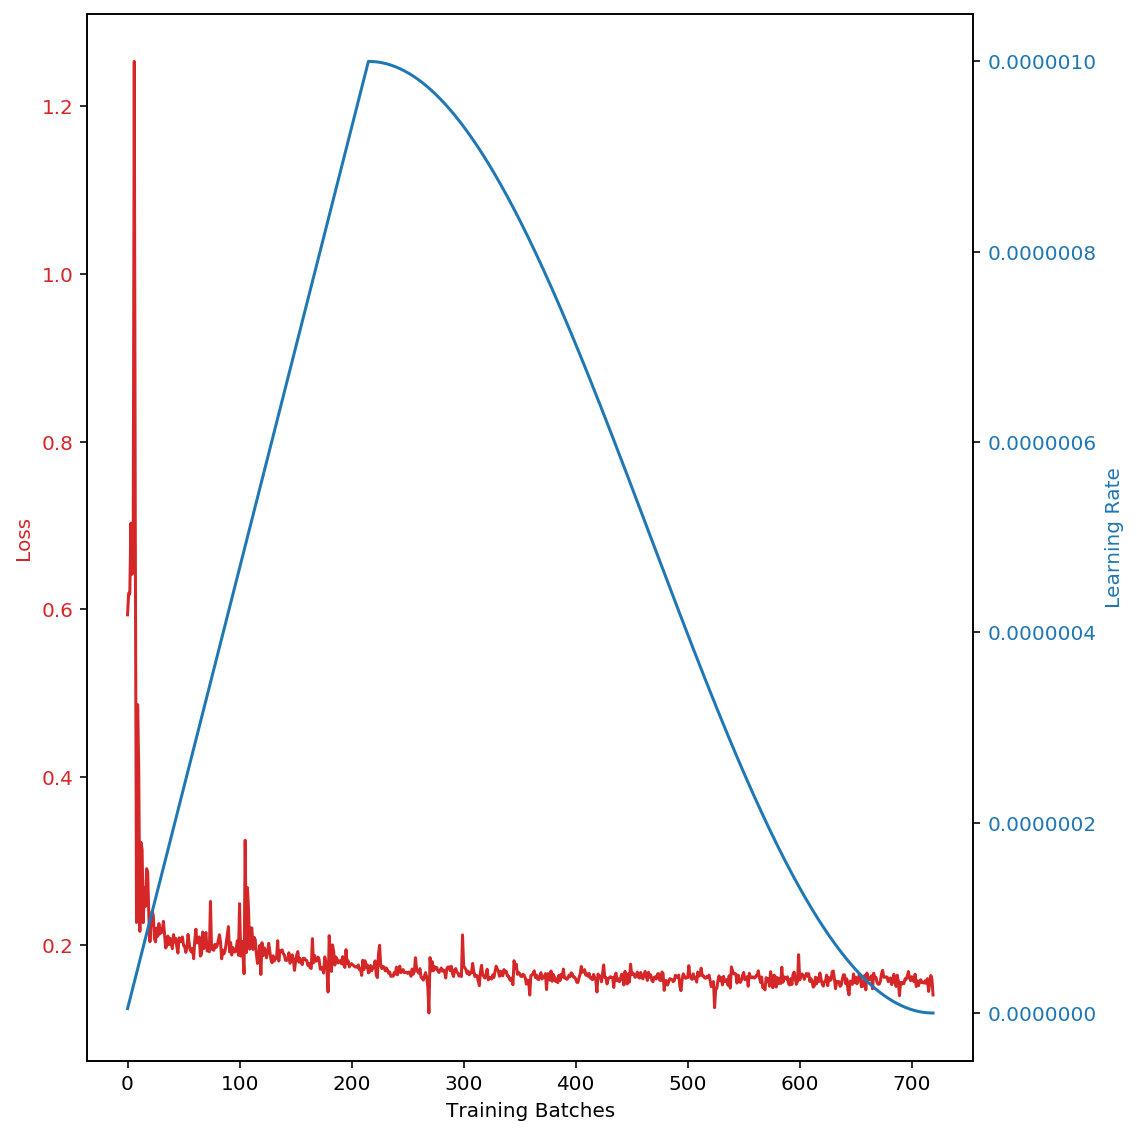

Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.431 0.586       0.289  0.000 0.000 1.000
1.000        0.521  0.527 0.433 0.587       0.636  1.000 0.000 1.000

,Probability,Predictions,Labels
431,0.579,1.000,0.000
1220,0.470,0.000,0.000
1205,0.443,0.000,0.000
697,0.463,0.000,0.000
934,0.459,0.000,1.000
1231,0.436,0.000,0.000
501,0.443,0.000,0.000
1188,0.502,1.000,1.000
1300,0.563,1.000,0.000
554,0.452,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.472 0.431 0.586       0.257  0.000 0.000 1.000
1.000        0.524  0.529 0.432 0.587       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
2349,0.482,0.000,1.000
6532,0.448,0.000,0.000
2011,0.487,0.000,1.000
7189,0.562,1.000,1.000
2411,0.453,0.000,0.000
4437,0.519,1.000,0.000
6179,0.440,0.000,0.000
1396,0.486,0.000,1.000
4780,0.439,0.000,1.000
6313,0.486,0.000,1.000


train   val
mean_or_std metric               
mean        map       0.665 0.625
            accuracy  0.712 0.683
            auc       0.773 0.727
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.790  0.743 0.766 4560.000     0.771  0.711 0.740 1140.000
pos     0.597  0.659 0.627 2640.000     0.560  0.636 0.596  660.000

In [11]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0, # 4.75
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)
# 0.0.760	0.745 (725	0.721) # 15m 41s


# Predict

## Normal Head

In [9]:
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


In [ ]:
epochs = 4
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[4],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)


## DETR Style head

In [ ]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0, # 4.75
                              dropout=0.1,
                              word_masking_proba=0.0,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

epochs = 4
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs,
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched, validation_epochs=[2, 5, 7],
                                           sampling_policy="without_replacement")
submission.to_csv("submission.csv",index=False)
submission.sample(10)



In [ ]:
# What train-auc does we achieve if all examples have same score.
# What train-auc does we achieve if all examples have random score.

In [18]:
submission.sample(10)

,id,proba,label
851,27180,0.491,0
358,7612,0.492,0
713,19672,0.492,0
879,85764,0.491,0
301,39247,0.491,0
307,4239,0.490,0
246,47863,0.491,0
393,26910,0.490,0
667,8567,0.491,0
506,82547,0.491,0
